In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import sys

from collections import defaultdict, OrderedDict
matplotlib.style.use('ggplot')

# import RidiculusTaxi
import mytaxi

In [2]:
env = gym.make('Taxi-v3').unwrapped
numS = env.observation_space.n
numA = env.action_space.n
print("#state:{}, #action{}".format(numS, numA))

#state:501, #action6


In [3]:
def my_argmax(Q_s):
    qmax = np.max(Q_s)
    actions = []
    for i,q in enumerate(Q_s):
        if q == qmax:
            actions.append(i)
    action=np.random.choice(actions)
    return action

def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
#         best_action = np.argmax(Q[observation])
        best_action = my_argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        A = A/sum(A)
        return A
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=0.9, epsilon=0.1):
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = make_epsilon_greedy_policy(Q, epsilon, numA)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        done = False
#         while not done:
        for t in range(1000):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            # The policy is improved implicitly by changing the Q dictionary
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
    return Q, policy

In [5]:
def plot_value_function(V, baseline, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    V_ordered = OrderedDict(sorted(V.items()))
    
    print('\n')
    print(len(V.keys()))
    
    v_s = np.zeros(len(V.keys()))
    idx = 0
    for key, val in V_ordered.items():
        v_s[idx] = val
        idx +=1

    # print(np.sort(np.asarray(V.keys())))

#     plt.plot(np.asarray(v_s), marker='o',linewidth=2)
    plt.plot(v_s,marker='o',linestyle='None',label='mc')
    plt.plot(baseline,marker='x',linestyle='None',label='base')
    plt.legend(["MC", "Baseline"])
    plt.title(title)
    plt.xlabel("State", fontsize=20)
    plt.savefig("MC_control.png")

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)
print("Q:{}".format(type(Q)))
print(Q.keys())

Episode 10000/10000.Q:<class 'collections.defaultdict'>
dict_keys([83, 63, 43, 143, 163, 263, 283, 383, 363, 183, 123, 23, 3, 243, 343, 443, 323, 423, 223, 483, 463, 103, 203, 303, 403, 19, 119, 139, 239, 39, 219, 339, 359, 439, 459, 259, 279, 179, 159, 326, 346, 426, 446, 246, 146, 226, 206, 106, 6, 26, 126, 266, 46, 166, 66, 86, 186, 306, 406, 286, 386, 366, 98, 78, 178, 198, 278, 258, 378, 398, 478, 498, 474, 374, 274, 254, 174, 74, 54, 94, 154, 134, 114, 14, 34, 194, 465, 365, 485, 385, 265, 245, 145, 125, 105, 25, 5, 225, 345, 325, 425, 205, 305, 405, 445, 285, 185, 165, 65, 85, 45, 97, 68, 168, 148, 248, 348, 328, 228, 428, 448, 188, 88, 268, 288, 48, 128, 28, 108, 208, 308, 408, 416, 316, 216, 236, 256, 276, 296, 176, 156, 136, 116, 368, 388, 488, 468, 8, 381, 281, 361, 261, 181, 481, 461, 161, 241, 221, 321, 121, 141, 21, 1, 17, 101, 117, 217, 237, 137, 157, 257, 277, 297, 197, 397, 377, 337, 437, 57, 77, 177, 37, 317, 417, 409, 357, 477, 473, 493, 393, 373, 457, 331, 431, 451,



500


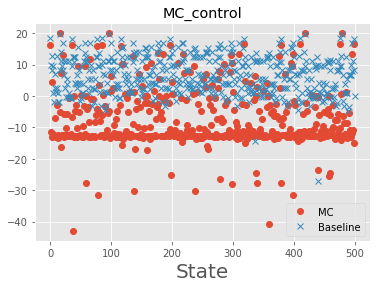

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
baseline = np.load('baseline.npy')
plot_value_function(V, baseline, title="MC_control")
# plot_Q_table()
with open('qtable_mc','w') as fp:
    fp.write(str(Q))